In [1]:
import pandas as pd
from pathlib import Path
indir = Path('/home/hsher/scratch/circ_nextera_iter13/output/edits')
df = pd.read_csv(list(indir.glob('YTHDF*.final_edit_score.tsv'))[0], index_col= 0, sep = '\t')

In [2]:
fa = '/home/hsher/scratch/circ_nextera_iter13/output/edits/YTHDF2_STAMP.final_edit_score.fa' # 200bp around edit
from Bio import SeqIO
seq_dict = {}
for record in SeqIO.parse(fa, "fasta"):
    seq_dict[record.id.split('::')[0]]=str(record.seq)
    

In [3]:
df['seq']=df['pos_id'].map(seq_dict)

In [4]:
df['is_GGACT']=df['seq'].str.contains('GGACT')
df['is_GGAC']=df['seq'].str.contains('GGAC')

In [5]:
# annotate with other stuffs

apo = pd.read_csv(list(indir.glob('APO*.final_edit_score.tsv'))[0], index_col= 0, sep = '\t')

In [6]:

hek1='/home/hsher/scratch/circ_nextera/output/edits/circseq-bm-rar11-nxt.final_edit_score.tsv'
hek1_df = pd.read_csv(hek1, index_col = 0, sep = '\t')

hek2='/home/hsher/scratch/circ_nextera_iter2/output/edits/HEK_rar11.final_edit_score.tsv'
hek2_df = pd.read_csv(hek2, index_col = 0, sep = '\t')

In [7]:
fdr_thres = 0.2
df['is_apo']=df['pos_id'].isin(apo['pos_id'])
df['is_apo_significant'] = df['pos_id'].isin(apo.loc[apo['FDR']<fdr_thres,'pos_id'])

df['is_hek2']=df['pos_id'].isin(hek2_df['pos_id'])
df['is_hek2_significant'] = df['pos_id'].isin(hek2_df.loc[hek2_df['FDR']<fdr_thres,'pos_id'])

df['is_hek1']=df['pos_id'].isin(hek1_df['pos_id'])
df['is_hek1_significant'] = df['pos_id'].isin(hek1_df.loc[hek1_df['FDR']<fdr_thres,'pos_id'])

In [8]:
common_circle = set(df['circ_id']
                   ).intersection(apo['circ_id']
                ).intersection(hek1_df['circ_id']
                              ).intersection(hek2_df['circ_id'])

In [9]:
len(common_circle)

5797

In [10]:
df = df.loc[df['circ_id'].isin(common_circle)]

In [11]:
df['is_significant']=(df['FDR']<fdr_thres)

In [12]:
from scipy.stats import chisquare
def chisquare_pv(pv):
    exp_freq = (pv.loc[False])/(pv.loc[False].sum())
    chi, p = chisquare(f_obs = pv.loc[True], f_exp = exp_freq*(pv.loc[True].sum())
                      )
    
    return p

Text(0.5, 1.0, 'chisq pval=0.00; F1=0.10')

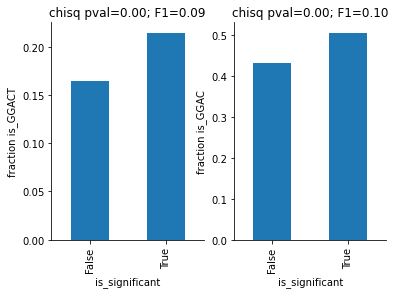

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

f, ax = plt.subplots(1,2)
col = 'is_GGACT'
df.groupby(by = ['is_significant'])[col].mean().plot.bar(ax = ax[0])
ax[0].set_ylabel(f'fraction {col}')

p=chisquare_pv(pd.pivot_table(df, index = 'is_significant', columns = col, aggfunc = 'size'))
f1=f1_score(df[col], df['is_significant'])
ax[0].set_title(f'chisq pval={p:.2f}; F1={f1:.2f}')

col = 'is_GGAC'
df.groupby(by = ['is_significant'])[col].mean().plot.bar(ax = ax[1])
ax[1].set_ylabel(f'fraction {col}')
sns.despine()
p=chisquare_pv(pd.pivot_table(df, index = 'is_significant', columns = col, aggfunc = 'size'))
f1=f1_score(df[col], df['is_significant'])
ax[1].set_title(f'chisq pval={p:.2f}; F1={f1:.2f}')

<AxesSubplot: ylabel='Frequency'>

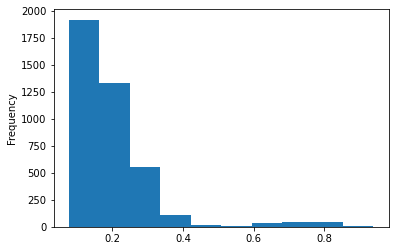

In [14]:
df['edit_fraction_above_0.3']=(df['edit_frac']>0.3)
df['edit_fraction_above_0.6']=(df['edit_frac']>0.6)
df.loc[df['is_significant'], 'edit_frac'].plot.hist()

In [15]:
df['coverage_bin']=pd.qcut(df['total'], q = 10)

In [16]:
df.loc[df['is_significant']]['coverage_bin'].value_counts()

(25.0, 39.0]      538
(53.0, 70.0]      466
(39.0, 53.0]      432
(70.0, 90.0]      412
(90.0, 116.0]     411
(7.999, 25.0]     388
(151.0, 200.0]    370
(280.0, 534.0]    364
(200.0, 280.0]    349
(116.0, 151.0]    341
Name: coverage_bin, dtype: int64

In [17]:
df['is_significant']

53        False
59        False
85        False
86        False
116       False
          ...  
432819     True
432841     True
432842     True
432866     True
432867     True
Name: is_significant, Length: 89259, dtype: bool

<AxesSubplot: xlabel='coverage_bin'>

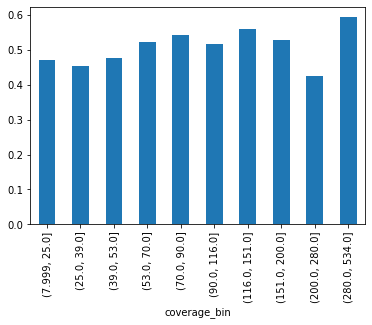

In [18]:
df.groupby(by = ['coverage_bin'])[col].mean().plot.bar()


df.loc[df['is_significant']].groupby(by = ['coverage_bin'])[col].mean().plot.bar()


In [19]:
pv = pd.pivot_table(df, index = 'is_significant', columns = col, aggfunc = 'size')

In [20]:
chisquare_pv(pv)

1.7242463076292933e-21

In [22]:
def test_multilevel_group(cnts, cond1):
    other=set([i[:len(cond1)] for i in cnts.index])
    other.remove(tuple(cond1))

    for other_cond in other:
        pv=chisquare_pv(pd.concat([cnts[cond1], cnts[other_cond]], axis = 1))
        print(other_cond, pv)

(False, True) 0.2763009682521791
(True, False) 0.14692411013715387
(False, False) 0.09524201552750862
(False, True) 0.2946369028008411
(True, False) 0.03737538627037142
(False, False) 5.6832504428078965e-05


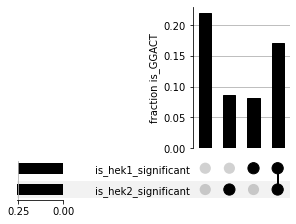

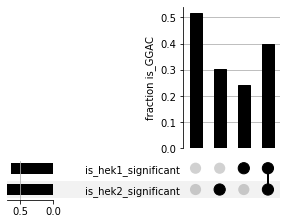

In [23]:
from upsetplot import plot
col = 'is_GGACT'
by = ['is_hek1_significant',
     'is_hek2_significant'
     ]
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')

cnts = df.loc[df['is_significant']].groupby(by = by
                                               )[col].value_counts()
cond1=tuple([True]*(len(by)))

test_multilevel_group(cnts, cond1)


col = 'is_GGAC'
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')
cnts = df.loc[df['is_significant']].groupby(by = by)[col].value_counts()
test_multilevel_group(cnts, cond1)

(False, True) 0.8434179700598889
(True, False) 0.04270073118725693
(True, True) 0.1275019256227813
(False, True) 0.09322047565560489
(True, False) 0.0010364639411213372
(True, True) 5.3281935377445896e-05


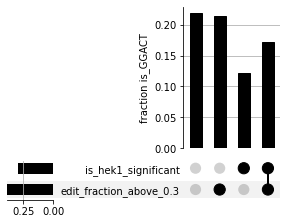

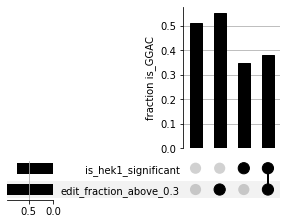

In [24]:
from upsetplot import plot
col = 'is_GGACT'
by = ['is_hek1_significant',
     'edit_fraction_above_0.3'
     ]
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')

cnts = df.loc[df['is_significant']].groupby(by = by
                                               )[col].value_counts()
cond1=tuple([False]*(len(by)))

test_multilevel_group(cnts, cond1)


col = 'is_GGAC'
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')
cnts = df.loc[df['is_significant']].groupby(by = by)[col].value_counts()
test_multilevel_group(cnts, cond1)

(False, True) 0.43087364499360825
(True, False) 0.013046024400196027
(True, True) 0.3930678525208017
(False, True) 0.5775689891353342
(True, False) 0.0005290562538122214
(True, True) 0.0020337440160398375


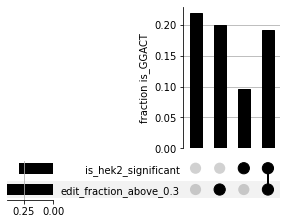

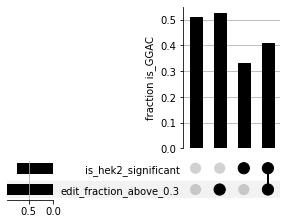

In [25]:
from upsetplot import plot
col = 'is_GGACT'
by = ['is_hek2_significant',
     'edit_fraction_above_0.3'
     ]
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')

cnts = df.loc[df['is_significant']].groupby(by = by
                                               )[col].value_counts()
cond1=tuple([False]*(len(by)))

test_multilevel_group(cnts, cond1)


col = 'is_GGAC'
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')
cnts = df.loc[df['is_significant']].groupby(by = by)[col].value_counts()
test_multilevel_group(cnts, cond1)

(True, False, True) nan
(True, True, False) 0.06625770983010404
(False, True, False) 0.12076428163885708
(True, False, False) 0.09029875121761397
(False, False, True) 0.025842300743513954
(True, True, True) 0.5749034374900108
(False, True, True) nan
---
(True, False, True) 0.1373604318318518
(True, True, False) 9.687147868814016e-09
(False, True, False) 0.005955037042271417
(True, False, False) 0.00029502903591001865
(False, False, True) 6.740831289885044e-06
(True, True, True) 0.3062708305423452
(False, True, True) nan


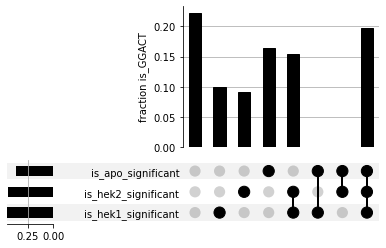

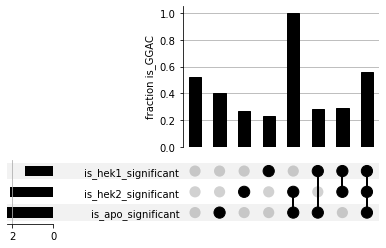

In [26]:
col = 'is_GGACT'
by = ['is_hek1_significant',
      'is_hek2_significant',
     'is_apo_significant'
     ]
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')

cnts = df.loc[df['is_significant']].groupby(by = by
                                               )[col].value_counts()
cond1=tuple([False]*(len(by)))

test_multilevel_group(cnts, cond1)
print('---')


col = 'is_GGAC'
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')
cnts = df.loc[df['is_significant']].groupby(by = by)[col].value_counts()
test_multilevel_group(cnts, cond1)

Text(0, 0.5, 'coverage')

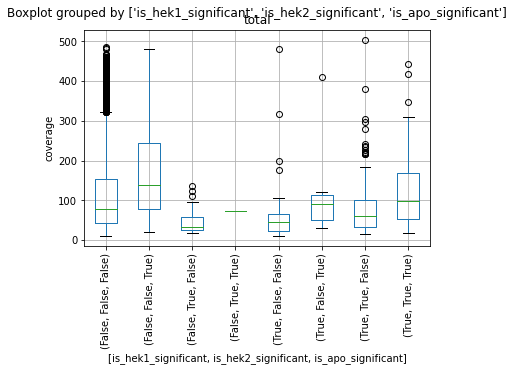

In [27]:
df.loc[df['is_significant']].boxplot(by = by, column = ['total'], rot = 90)
plt.ylabel('coverage')

Text(0, 0.5, 'coverage')

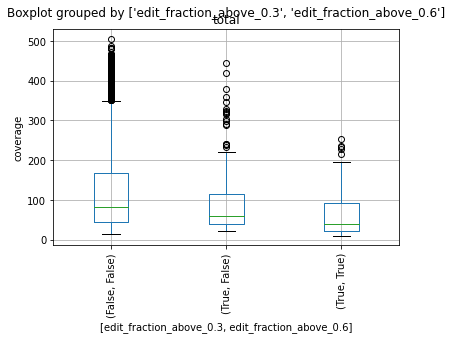

In [28]:
df.loc[df['is_significant']].boxplot(by = ['edit_fraction_above_0.3',
                                          'edit_fraction_above_0.6'
                                          ], column = ['total'], rot = 90)
plt.ylabel('coverage')

(True, False) 0.5184171990519574
(False, False) 0.2701624653268056
(True, False) 2.613276786743364e-07
(False, False) 4.724846443468322e-06


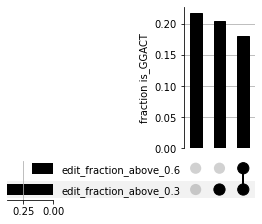

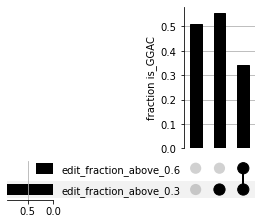

In [29]:
from upsetplot import plot
col = 'is_GGACT'
by = ['edit_fraction_above_0.3',
    'edit_fraction_above_0.6'
    ]
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')

cnts = df.loc[df['is_significant']].groupby(by = by
                                               )[col].value_counts()
cond1=tuple([True]*(len(by)))

test_multilevel_group(cnts, cond1)


col = 'is_GGAC'
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')
cnts = df.loc[df['is_significant']].groupby(by = by)[col].value_counts()
test_multilevel_group(cnts, cond1)

(True, False, True) 0.8264440101673718
(True, True, False) 0.882783191152826
(False, False, False) 0.30811761220590345
(True, False, False) 0.36485627479772165
(False, False, True) 0.3103634945279252
(True, False, True) 0.13732267023858508
(True, True, False) 0.9151060344205056
(False, False, False) 0.00011292443319134254
(True, False, False) 1.1068365014849337e-07
(False, False, True) 0.9077591800533312


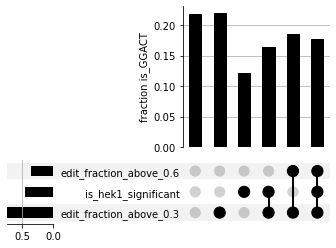

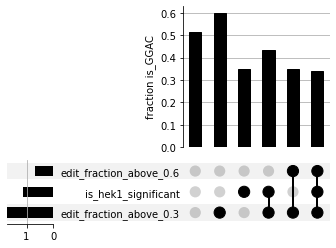

In [30]:
col = 'is_GGACT'
by = ['edit_fraction_above_0.3',
    'edit_fraction_above_0.6',
      'is_hek1_significant'
      
    ]
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')

cnts = df.loc[df['is_significant']].groupby(by = by
                                               )[col].value_counts()
cond1=tuple([True]*(len(by)))

test_multilevel_group(cnts, cond1)


col = 'is_GGAC'
plot(df.loc[df['is_significant']].groupby(by = by)[col].mean()
    )
plt.ylabel(f'fraction {col}')
cnts = df.loc[df['is_significant']].groupby(by = by)[col].value_counts()
test_multilevel_group(cnts, cond1)

Text(0, 0.5, 'fraction is_GGACT')

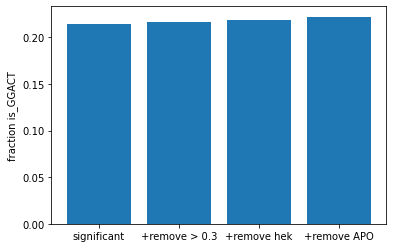

In [31]:
col = 'is_GGACT'
plt.bar([1,2,3,4],[
df.loc[df['is_significant'], col].mean(),
df.loc[(df['is_significant'])&(~df['edit_fraction_above_0.3']), col].mean(),
df.loc[df['is_significant']&(~df['is_hek1_significant'])&(~df['is_hek2_significant']&(~df['edit_fraction_above_0.3'])), col].mean(),
df.loc[df['is_significant']&(~df['is_hek1_significant'])&(~df['is_hek2_significant'])&(~df['edit_fraction_above_0.3'])&(~df['is_apo_significant'])
                                                       , col].mean(),
])

plt.xticks([1,2,3,4],['significant', '+remove > 0.3', '+remove hek', '+remove APO'])
plt.ylabel(f'fraction {col}')


Text(0, 0.5, 'fraction is_GGAC')

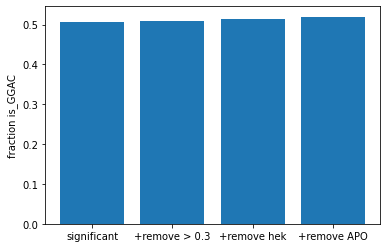

In [32]:
col = 'is_GGAC'
plt.bar([1,2,3,4],[
df.loc[df['is_significant'], col].mean(),
df.loc[(df['is_significant'])&(~df['edit_fraction_above_0.3']), col].mean(),
df.loc[df['is_significant']&(~df['is_hek1_significant'])&(~df['is_hek2_significant']&(~df['edit_fraction_above_0.3'])), col].mean(),
df.loc[df['is_significant']&(~df['is_hek1_significant'])&(~df['is_hek2_significant'])&(~df['edit_fraction_above_0.3'])&(~df['is_apo_significant'])
                                                       , col].mean(),
])

plt.xticks([1,2,3,4],['significant', '+remove > 0.3', '+remove hek', '+remove APO'])
plt.ylabel(f'fraction {col}')


In [33]:
most_stringent=df.loc[df['is_significant']&(~df['is_hek1_significant'])&(~df['is_hek2_significant'])&(~df['edit_fraction_above_0.3'])&(~df['is_apo_significant'])]

<AxesSubplot: >

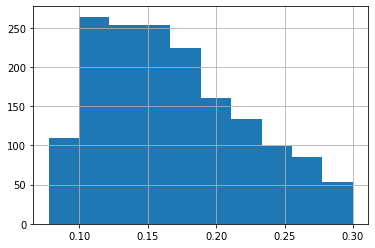

In [34]:
most_stringent.loc[~most_stringent['is_GGAC'], 'edit_frac'].hist()

<AxesSubplot: >

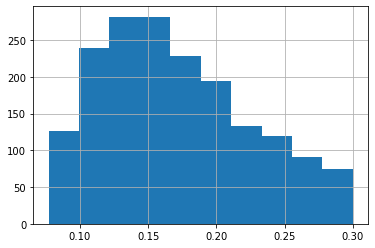

In [35]:
most_stringent.loc[most_stringent['is_GGAC'], 'edit_frac'].hist()

<AxesSubplot: xlabel='total', ylabel='Proportion'>

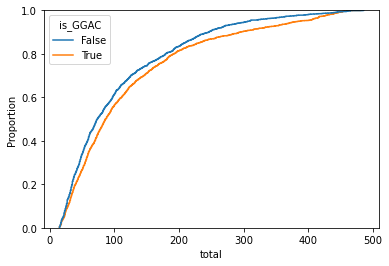

In [36]:
sns.ecdfplot(most_stringent, hue = 'is_GGAC', x = 'total')

<AxesSubplot: xlabel='edit_frac', ylabel='Proportion'>

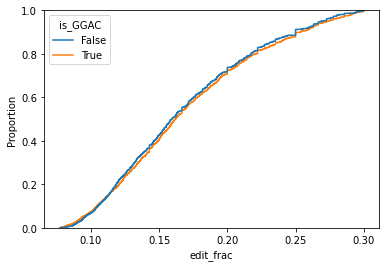

In [38]:
sns.ecdfplot(most_stringent, hue = 'is_GGAC', x = 'edit_frac')